In [50]:
import json
import warnings

import gdown
import geopandas as gpd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import streamlit as st
from tqdm import tqdm
import xarray as xr
import xgboost as xgb

warnings.filterwarnings("ignore")
plt.style.use("seaborn")

## Initial Data Exploration - Scalloped Hammerhead Shark
This notebook does the following:
- Loads in the scalloped hammerhead shark data downloaded from [GBIF](https://www.gbif.org/occurrence/download?taxon_key=2418789)
- Defines the accessible area for the shark based on visualisation and general scientific understanding

### 1. Raw Species Data

#### 1.1  Download and Process Presence Data
- Stored all data in a public Google Drive link for ease

In [ ]:
url = "https://drive.google.com/drive/folders/10PrHepxwE45PAGGKIFgTfXlLrJ52NFwy?usp=drive_link"
gdown.download_folder(url, output="../", quiet=False, use_cookies=False)

In [ ]:
def load_raw_presence_data(filepath):
    df = pd.read_csv(filepath, sep='\t', on_bad_lines="skip")
    print(f"Species Counts: {df['species'].nunique()}")
    print(f"Initial number of rows: {df.shape[0]}")
    return df

def filter_basic_issues_from_dataset(df, coord_uncertainty_threshold=500, remove_uncertainty_nans=True):
    # Note - may want to be more lenient here depending on how dynamic the env variables are at short distances
    num_to_remove = ((df["coordinateUncertaintyInMeters"] >= coord_uncertainty_threshold)).sum()
    df = df[(df["coordinateUncertaintyInMeters"] < coord_uncertainty_threshold) |
            (df["coordinateUncertaintyInMeters"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on coordinate uncertainty, leaving {df.shape[0]} rows")
    
    if remove_uncertainty_nans:
        num_to_remove = (df["coordinateUncertaintyInMeters"].isna()).sum()
        df = df[~(df["coordinateUncertaintyInMeters"].isna())].reset_index(drop=True)
        print(f"Filtered out {num_to_remove} rows based on missing coordinate uncertainty, leaving {df.shape[0]} rows")
    
    # Remove rows with no lat/lon
    num_to_remove = (df["decimalLatitude"].isna() | df["decimalLongitude"].isna()).sum()
    df = df[~(df["decimalLatitude"].isna()) & ~(df["decimalLongitude"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on missing lat/lon, leaving {df.shape[0]} rows")
    df = df.rename(columns={"decimalLatitude": "latitude", "decimalLongitude": "longitude"})
    return df

In [26]:
presence_df = load_raw_presence_data('../data/gbif/scalloped_hammerhead.csv')
presence_df = filter_basic_issues_from_dataset(presence_df, coord_uncertainty_threshold=500, remove_uncertainty_nans=False)
presence_df = presence_df[[
    "latitude",
    "longitude",
    "year"
]]
presence_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.longitude, presence_df.latitude),
    crs="EPSG:4326"  # Latitude, longitude, in degrees
)

Species Counts: 1
Initial number of rows: 28365
Filtered out 3001 rows based on coordinate uncertainty, leaving 25364 rows
Filtered out 1661 rows based on missing lat/lon, leaving 23703 rows


#### 1.2 Initial Visualization
- Helps to define appropiate accessible area
- Load in coastline data as map overlay
- Longitude actually is the entire range (-180, 180)
- Latitude does have some limits
- Could be worth limiting our search initially to one continent, to start with. E.g. many points in North America.

In [ ]:
coastline = gpd.read_file("../data/environmental/ne_10m_coastline/ne_10m_coastline.shp")

In [37]:
padding=2.0
max_lon = presence_gdf["longitude"].max() + padding
min_lon = presence_gdf["longitude"].min() - padding
max_lat = presence_gdf["latitude"].max() + padding
min_lat = presence_gdf["latitude"].min() - padding

# Correction
max_lon = 180
min_lon = -180

In [38]:
def visualise_data_on_map(coastline, points_dfs=[], points_dfs_colors=[], points_dfs_labels=[], coastline_alpha=1, 
                          plot_bounding_box=True, limit_to_bounding_box=False, accessible_area=None, show_plot=True):
    coastline = coastline.to_crs(epsg=4326)
    coastline.plot(color="black", linewidth=0.5, figsize=(20,10), label="Coastline", alpha=coastline_alpha)
    for i, points_df in enumerate(points_dfs):
        plt.scatter(points_df["longitude"], points_df["latitude"], s=5, label=points_dfs_labels[i], color=points_dfs_colors[i])

    if plot_bounding_box:
        plt.plot([min_lon, min_lon, max_lon, max_lon, min_lon],
                [min_lat, max_lat, max_lat, min_lat, min_lat], color='blue', alpha=0.5, linewidth=1, label="Accessible Area")
        
    if accessible_area is not None:
        accessible_area.plot(
            cmap="Blues",
            alpha=0.4,
            add_colorbar=False,
            label="Accessible Area"
        )
        
    if limit_to_bounding_box:
        plt.xlim(min_lon - 2, max_lon + 2)
        plt.ylim(min_lat - 2, max_lat + 2)

    plt.axis('off')
    if show_plot:
        plt.legend()
        plt.show()

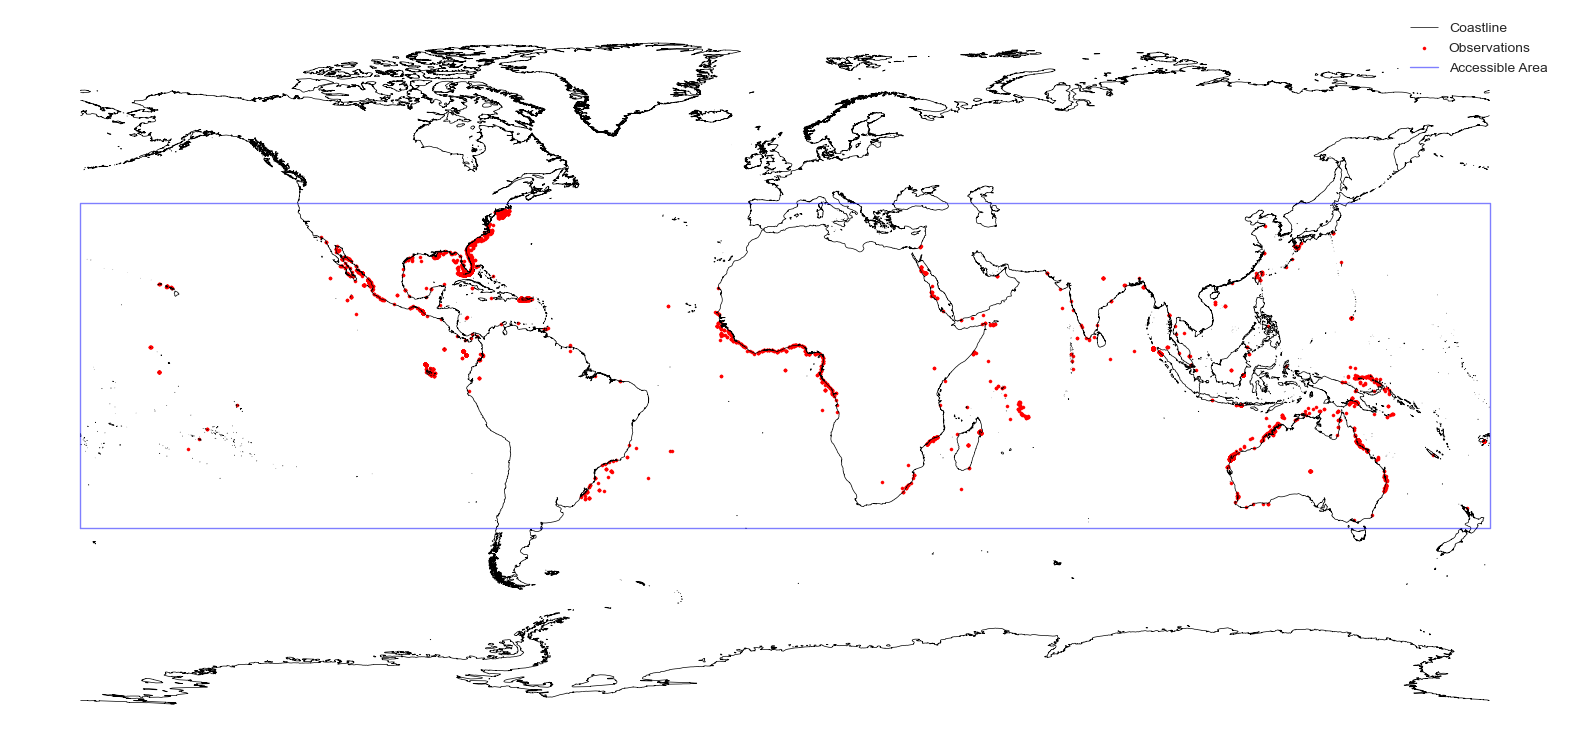

In [39]:
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"])

### 3. Accessible Area Creation
Using the map and also [this source](https://www.fishbase.se/summary/912) we filter to the following accessible area to begin with:
- No land
- Latitude -39 to 46
- Longitude -180 to 180
- If we want to be more specific, we can filter to the distribution areas found in the fishbase source above.
- Another consideration: Depth 0 to 1043m - typically 0-25m. However, we can't filter the area based on bathymetry because the shark isn't only at the bottom, it can be anywhere on the depth axis.

We will use this to:
- Filter presence data to be within this area only
- Sample appropriate background data

In [41]:
MIN_LAT = -39
MAX_LAT = 46

In [42]:
def create_accessible_area(ref_coordinate_space_dataset_path="../data/environmental/bio_oracle/bathymetry.nc"):
    """
    Criteria:
    - -39 to 36 longitude
    - No land
    """
    ds = xr.open_dataset(ref_coordinate_space_dataset_path)
    bathy = ds["bathymetry_mean"]

    lons = bathy["longitude"].values
    lats = bathy["latitude"].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    region_mask = (
        (lat2d >= MIN_LAT) & (lat2d <= MAX_LAT)
    )

    ocean_mask = np.isfinite(bathy.values)[0]
    accessible_area_mask = ocean_mask & region_mask

    accessible_area = xr.DataArray(
        accessible_area_mask.astype(np.uint8),
        coords={"latitude": bathy["latitude"], "longitude": bathy["longitude"]},
        dims=("latitude", "longitude"),
        name="M_accessible"
    )
    return accessible_area_mask, accessible_area

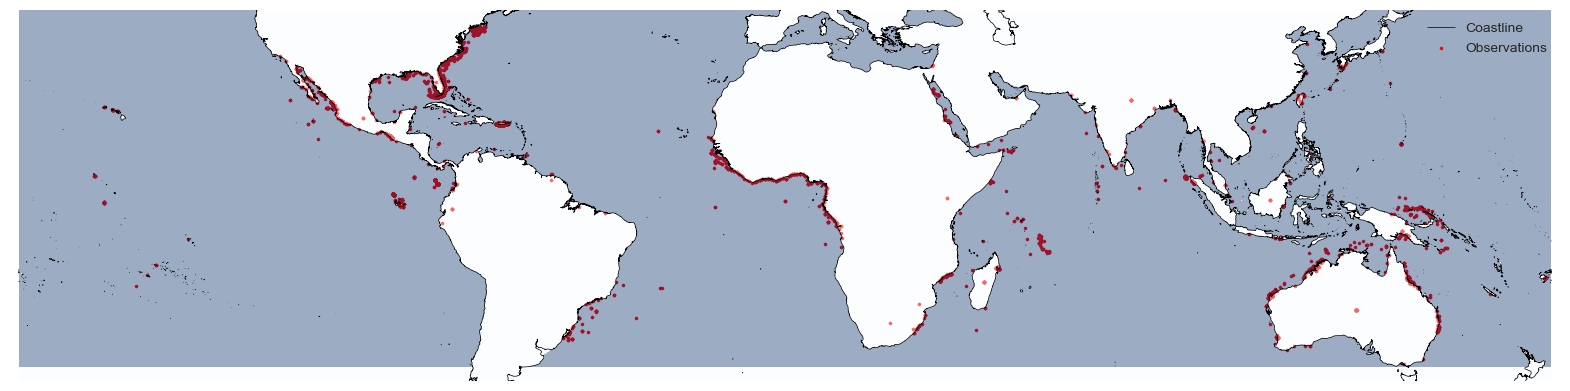

In [ ]:
accessible_area_mask, accessible_area = create_accessible_area()
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"], accessible_area=accessible_area,
                      plot_bounding_box=False, limit_to_bounding_box=True)

### 3. Filter Presence Data
- Ensure it is within the accessible area only. This will remove those on land or outside the known latitudinal range.
- TODO: seems like way more is removed than I expected. One of three things:
  - The lack of granularity in bathymetry dataset cooredinates is linking many close-to-shore observations as on-shore 
  - People have classed their observations as shore-based instead of sea-based, but only just
  - There are undefined bathymetry values in the sea, i.e. I can't assume undefined <-> on land

In [45]:
def filter_data_to_be_within_accessible_area(gdf):
    gdf = gdf.to_crs(epsg=4326)
    gdf_filtered = gdf[
        gdf.geometry.apply(lambda point: accessible_area.sel(longitude=point.x, latitude=point.y, method="nearest").values == 1)
    ].reset_index(drop=True)
    gdf_removed = gdf[~gdf.index.isin(gdf_filtered.index)].reset_index(drop=True)
    n_removed = gdf.shape[0] - gdf_filtered.shape[0]
    print(f"Filtered out {n_removed} rows based on accessible area, leaving {gdf_filtered.shape[0]} rows")
    return gdf_filtered, gdf_removed

Filtered out 2666 rows based on accessible area, leaving 21037 rows


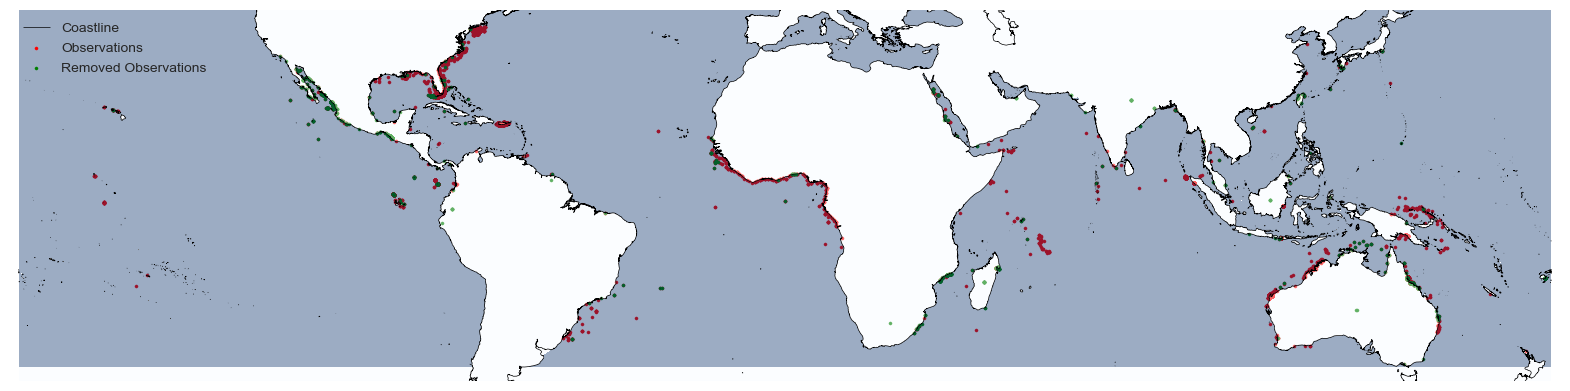

In [46]:
presence_gdf_filtered, presence_gdf_removed = filter_data_to_be_within_accessible_area(presence_gdf)

# Plotting removed points also to see if I didn't capture some important areas/variables
visualise_data_on_map(coastline, [presence_gdf_filtered, presence_gdf_removed], ["red", "green"], ["Observations", "Removed Observations"],
                      accessible_area=accessible_area, plot_bounding_box=False, limit_to_bounding_box=True)